# Práctica 1. Aprendizaje Automático

Authors: Carlos Iborra Llopis (100451170), Alejandra Galán Arrospide (100451273) <br>
Link al repositorio de GitHub: https://github.com/carlosiborra/Grupo02-Practica1-AprendizajeAutomatico

# 0. Table of contents

- [Práctica 1. Aprendizaje Automático](#práctica-1-aprendizaje-automático)
  - [0. Table of contents](#0-table-of-contents)
  - [1. Requirements](#1-requirements)
  - [2. Reading the datasets](#2-reading-the-datasets)
  - [3. Exploratory Data Analysis](#3-EDA)

# 1. Requirements


In [2]:
""" Importing necessary libraries """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as st
import scipy
import sklearn

from matplotlib.cbook import boxplot_stats as bps

### 1.1. Cleaning ../data/img/ folder
This way we avoid creating multiple images and sending the old ones to the trash.<br>
Also using this to upload cleaner commits to GitHub.


In [3]:
""" Cleaning the ../data/img/ folder """
import os
import glob

files = glob.glob("../data/img/*")
for f in files:
    if os.path.isfile(f) and f.endswith(".png"):
        os.remove(f)

files = glob.glob("../data/img/box-plot/*")
for f in files:
    if os.path.isfile(f) and f.endswith(".png"):
        os.remove(f)

---
# 2. Reading the datasets
Reading the datasets from the bz2 files, group 2.

In [4]:
""" Reading the dataset """
disp_df = pd.read_csv("../data/disp_st2ns1.txt.bz2", compression="bz2", index_col=0)
comp_df = pd.read_csv("../data/comp_st2ns1.txt.bz2", compression="bz2", index_col=0)

---
# 3. EDA

**Key Concepts of Exploratory Data Analysis**

- **2 types of Data Analysis**
  - Confirmatory Data Analysis
  - Exploratory Data Analysis
- **4 Objectives of EDA**
  - Discover Patterns
  - Spot Anomalies
  - Frame Hypothesis
  - Check Assumptions
- **2 methods for exploration**
  - Univariate Analysis
  - Bivariate Analysis
- **Stuff done during EDA**
  - Trends
  - Distribution
  - Mean
  - Median
  - Outlier
  - Spread measurement (SD)
  - Correlations
  - Hypothesis testing
  - Visual Exploration


## 3.0. Dataset preparation

To conduct exploratory data analysis (EDA) on our real data, we need to prepare the data first. Therefore, we have decided to separate the data into training and test sets at an early stage to avoid data leakage, which could result in an overly optimistic evaluation of the model, among other consequences. This separation will be done by dividing the data prematurely into training and test sets since potential data leakage can occur from the usage of the test partition, especially when including the result variable.

It is important to note that this step is necessary because all the information obtained in this section will be used to make decisions such as dimensionality reduction. Furthermore, this approach makes the evaluation more realistic and rigorous since the test set is not used until the end of the process.




In [ ]:
""" Train Test Split (time series) """

# * Make a copy of the dataframe (as Padas dataframe is mutable, therefore uses a reference)
disp_df_copy = disp_df.copy()

# print(disp_df)
# print(disp_df_copy)

# Now we make the train_x, train_y, test_x, test_y splits taking into account the time series
# Note: the time series is ordered by date, therefore we need to split the data in a way that the train data is before the test data
# Note: the 10 first years are used for training and the last two years for testing
# Note: this is done because if not, we will be predicting the past from the future, which leads to errors and overfitting (data leakage) in the model

# * Calculate the number of rows for training and testing
num_rows = disp_df_copy.shape[0]
num_train_rows = int(
    num_rows * 10 / 12
)  # 10 first years for training, 2 last years for testing

# * Split the data into train and test dataframes (using iloc instead of train_test_split as it picks random rows)
train_df = disp_df_copy.iloc[
    :num_train_rows, :
]  # train contains the first 10 years of rows
test_df = disp_df_copy.iloc[
    num_train_rows:, :
]  # test contains the last 2 years of rows

# Print the number of rows for each dataframe
print(f"Number of rows for training (EDA): {train_df.shape[0]}")
print(f"Number of rows for testing: {test_df.shape[0]}")


# ! We maintain the original dataframe for later use (as we will divide it into train and test dataframes below)
# ! For the EDA, we will use the train_df dataframe (with the outpout variable).

## 3.1. Dataset description

- **apcp_sfc**: 3-Hour accumulated precipitation at the surface (kg·m⁽⁻²⁾)
- **dlwrf_sfc**: Downward long-wave radiative flux average at the surface (W·m⁽⁻²⁾)
- **dswrf_sfc**: Downward short-wave radiative flux average at the surface (W·m⁽⁻²⁾)
- **pres_msl**: Air pressure at mean sea level (Pa)
- **pwat_eatm**: Precipitable Water over the entire depth of the atmosphere (kg·m⁽⁻²⁾)
- **spfh_2m**: Specific Humidity at 2 m above ground (kg·kg⁽⁻¹⁾)
- **tcdc_eatm**: Total cloud cover over the entire depth of the atmosphere (%)
- **tcolc_eatm**: Total column-integrated condensate over the entire atmos. (kg·m⁽⁻²⁾)
- **tmax_2m**: Maximum Temperature over the past 3 hours at 2 m above the ground (K)
- **tmin_2m**: Mininmum Temperature over the past 3 hours at 2 m above the ground (K)
- **tmp_2m**: Current temperature at 2 m above the ground (K)
- **tmp_sfc**: Temperature of the surface (K)
- **ulwrf_sfc**: Upward long-wave radiation at the surface (W·m⁽⁻²⁾)
- **ulwrf_tatm**: Upward long-wave radiation at the top of the atmosphere (W·m⁽⁻²⁾)
- **uswrf_sfc**: Upward short-wave radiation at the surface (W·m⁽⁻²⁾)


In [ ]:
# Display all the columns of the dataframe
pd.set_option("display.max_columns", None)

train_df.describe()

In [ ]:
train_df.shape

In [ ]:
train_df.head()

In [ ]:
train_df.info()

## 3.2. Missing values


Fist, we check the number the total number of missing values in the dataset in order to know if we have to clean the dataset or not.

In [ ]:
train_df.isna().sum()

As we can oberve, there are no missing values in the dataset, but theres still the possibility of having missing values measured as 0's, so we will check if all those zeros make sense in the context of the dataset or not.

In [ ]:
# In the plot, we can see that there are a lot of 0 values in the dataset
train_df.plot(legend=False, figsize=(15, 5))

In [ ]:
result = train_df.eq(0.0).sum() / len(train_df) * 100

# Select those columns with more than 30% of zeros
result = result[result > 30.0]
result = result.sort_values(ascending=False)
result

### Observations

As output of the previous cell, we can see that there exist a lot of zeros in the dataset, let's analize if those zeros make sense or not.

The variables with most ammount of zeros (>30%) are:

- **dswrf_s1_1**: Downward short-wave radiative flux average at the surface, at 12:00 UTC, normal to have a lot of zeros as it is not sunny at 12:00
- **uswrf_s1_1**: Upward short-wave radiation at the surface, at 12:00 UTC, normal to have a lot of zeros as it is not sunny at 12:00
- **apcp_s**: 3-Hour accumulated precipitation at the surface, as it is not raining every day, it is normal to have a lot of zeros
- **tcdc_ea**: Total cloud cover over the entire depth of the atmosphere, as it is not cloudy every day, it is normal to have a lot of zeros


First, lets start by assigning the zeros to NaNs. By doing this we can visualize the varibles that take more values other than zero.


In [ ]:
disp_df_nan = train_df.replace(0.0, np.nan)

In [ ]:
""" Plotting missing values """
# Sustitute 0.0 values with NaN and plot the name of the columns with missing values
# ? msno.bar is a simple visualization of nullity by column
msno.bar(disp_df_nan, labels=True, fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_bar.png")

In [ ]:
""" Plotting the missing values in a matrix """

# ? The msno.matrix nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion.
msno.matrix(disp_df_nan)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_matrix.png")

In [ ]:
""" Plotting the missing values in a heatmap """
# As in a hetmap not every value is shown, we must delimit the values to the ones with more than 30% of missing values
result = disp_df.eq(0.0).sum() / len(disp_df) * 100
result = result[result > 30.0]  # Select those columns with more than 30% of zeros
result = result.sort_values(ascending=False)
result = result.index.tolist()  # Convert to list
result

# ? The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another
msno.heatmap(disp_df_nan[result], fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_heatmap.png")

In [ ]:
""" Plotting the dendrogram """

# ? The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap:
msno.dendrogram(disp_df_nan, orientation="top", fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_dendrogram.png")

### Conclusions
In this section, we have observe that there are no attibutes with 'Null' nor 'NaN' nor 'None' values. This indicated that at a first glance, the data is clean, at least of those datatypes.

In second place, we have observed that the attributes that we suspected could have an important number of missing values (represented by 0 instead of the previously mentioned), had instead valuable information, as we have proved along this section.<br>Since the data is clean and we have concluded there are no missing values, we do not need to complete them using a model or other methods, so we can move on to the next step, observing the outliers.

## 3.3. Outliers


Detecting outliers in a dataset before training a model is crucial because outliers can significantly affect the performance and accuracy of the model. Outliers are data points that deviate significantly from the rest of the dataset and can cause the model to learn incorrect patterns and relationships. When outliers are present in the data, they can also increase the variance of the model, which can result in overfitting. Overfitting occurs when the model fits too closely to the training data, leading to poor generalization to new data. Therefore, it is important to detect and handle outliers appropriately to ensure the model's accuracy and robustness.

In [ ]:
list_of_attributes = train_df.columns.values.tolist()
#print(list_of_attributes)

In [ ]:
# Boxplot with all attributes in the dataset
# sns.boxplot(data=train_df, orient="h")
# plt.show()

In [ ]:
train_df.describe()

In [ ]:
train_df['apcp_sf1_1'].value_counts()

Here, by plotting the boxplots and making the outliers (fliers) visible, we are able to see some outliers in the dataset.<br>
Take into account that the outliers are represented by the points outside the boxplot and they can be potentially wrong values or just values that are not usual in the dataset (ruido).

### 3.3.1. Histogram to identify outliers

In [ ]:
""" Histogram showing the distribtuion of train_df to show the outliers """
plt.hist(train_df)
plt.show()

### 3.3.2. Boxplot to identify outliers

With the objective of noticing the outliers on each attribute, we create a box-plot of each of the attributes 

In [ ]:
""" Plotting the boxplot for each attribute and getting the outliers of each attribute """
total_outliers = []
# * We iterate over the list of attributes
for attribute in list_of_attributes:
    # * sns.regplot(x=train_df[attribute], y=train_df['total'], fit_reg=False)
    sns.boxplot(data=train_df[attribute], x=train_df[attribute], orient="h")
    # * Use the command below to show each plot (small size for visualization sake)
    # sns.set(rc={'figure.figsize':(1,.5)})
    # plt.show()
    # * All the images are saved in the folder ../data/img/box-plot
    plt.savefig(f"../data/img/box-plot/{str(attribute)}.png")

    # We obtain the a list of outliers for each attribute
    list_of_outliers = train_df[attribute][train_df[attribute] > train_df[attribute].quantile(0.75) + 1.5*(train_df[attribute].quantile(0.75) - train_df[attribute].quantile(0.25))].tolist()
    outliers = [f'{attribute} outliers'] + [len(list_of_outliers)] + [list_of_outliers]
    # * In order to print the total number of outliers for each attribute
    # print(f'{attribute} has {len(list_of_outliers)} outliers')
    # ! Data structure: [attribute, number of outliers, list of outliers]
    # print(outliers)
    total_outliers.append(outliers)

# print the first 2 elements of each element in the list -> [[atb, num],[atb, num],...]
num_atb_outliers = 0
for i in total_outliers:
    if i[1] != 0:
        num_atb_outliers += 1
        print(f"{i[0:2]}...")
        
# Number of outliers != 0 for each attribute
print(f"Total number of atributes with outliers: {num_atb_outliers} / {len(total_outliers)-1}")

We managed to create a list containing the name of the atribute, the number of outliers and the value of the outliers for each attribute, calculated by applying the IQR method.<br> This is relevant as we managed to create a 'total_outliers' variable that contains the list data structures of all the different outliers from all the attributes, so that it can be easily accessed in a future to remove the outliers from the dataset if needed for testing purposes.

As suspected, we can see that **there are a lot of outliers in the dataset**, therefore it is plausible that some of them are noise, thus possibly being removed in a future model in order to improve it (either by hand or by selection in the preprocess pipeline).<br>Now, we need to analyze if they are the result of bad measurements or if they are significant data for the analysis.


Additionaly, as we will see later, this amount of outliers indicate us that probably a Robust Scaler will be more appropriate than using a Standard Scaler, as the Robust Scaler is more robust to outliers than the Standard Scaler, thus being more appropriate for this dataset model.

### 3.3.3. Skewness and Kurtosis to identify outliers
Skewness and kurtosis are commonly used to measure the shape of a distribution. Skewness measures the degree of asymmetry in the distribution, while kurtosis measures the degree of flatness in the distribution compared to a normal distribution.
We will look for observations that are far from the central tendency of the distribution and may indicate the presence of extreme values or data points that do not fit the pattern of the majority of the data (which as expected, happens to be the case in this dataset).

In [ ]:
""" Skewness """
# ? skewness: measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.
train_df.skew().sort_values(ascending=False)

In [ ]:
""" Kurtosis """
# ? kurtosis: measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
train_df.kurt().sort_values(ascending=False)

In [ ]:
y = train_df["apcp_sf4_1"]
plt.figure(1)
plt.title("Normal")
sns.distplot(y, kde=True, fit=st.norm)
plt.figure(2)
plt.title("Log Normal")
sns.distplot(y, kde=True, fit=st.lognorm)

In [ ]:
sns.distplot(train_df.skew(), color="blue", axlabel="Skewness")

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(
    train_df.kurt(), color="r", axlabel="Kurtosis", norm_hist=False, kde=True, rug=False
)
# plt.hist(train.kurt(),orientation = 'vertical',histtype = 'bar',label ='Kurtosis', color ='blue')
plt.show()

## 3.4. Correlation


In this section we are getting information about the correlation of the variables between them. This information is valuable in order to make good decisions when deleting redundant attributes. Also note we are getting information about the correlation between each attribute and the solution variable. This allows us to know the most relevant attributes, making the best decisions when creating the different models.  

In [ ]:
correlation = train_df.corr()
correlation = abs(correlation)
print(correlation.shape)  # 76 x 76 matrix of correlation values

### Getting the correlation matrix formatted into our own data structure
This is done for the sake of simplicity and to be able to visualize the correlation matrix in a more intuitive way.


In [ ]:
correlation_list = []

for column in train_df.columns:
    correlation.loc[:, column] = abs(
        correlation.iloc[:, train_df.columns.get_loc(column)]
    )
    mask = correlation.loc[:, column] > 0.95
    # print(correlation[column][mask].sort_values(ascending = False))

    # Translate the comment below to English:
    # we add the correlation values to a list of lists, which contains the names of the correlated columns and their correlation index

    # The first segment adds the name of the column we are analyzing
    # The second segment adds the names of the columns correlated (except the column we are analyzing) > 0.95
    # The third segment adds the correlation index of the columns correlated (except the column we are analyzing) > 0.95
    # Second and third segment are added to the first segment as a list of lists

    # First we need to create a dictionary with the column names and their correlation values (except the column we are analyzing)
    dict = {
        key: value
        for key, value in correlation.loc[column, mask]
        .sort_values(ascending=False)
        .iloc[1:]
        .to_dict()
        .items()
    }
    # print (dict)

    # Then we create a list of lists with the column names and their correlation values from the dictionary created above
    corr_list = [[key] + [value] for key, value in dict.items()]
    # Finally we add the name of the column we are analyzing to the list of lists created above as the first element of the list (str)
    corr_list.insert(0, ["Columna: " + column])

    # ! Data structure: [[columna, [columna correlada 1, indice de correlacion], [columna correlada 2, indice de correlacion], ...], ...]
    print(corr_list)

    correlation_list += [corr_list]
print(correlation_list)

### Correlation Heat Map

In [ ]:
""" seaborne Correlation Heat Map """
# It needs to show all the columns
fig, ax = plt.subplots(figsize=(19, 18))

plt.title("Correlation Heat Map", y=1)
# We use blue color scale because it is easier to see the annotations and the correlation values
sns.heatmap(
    correlation,
    square=True,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 4},
    cbar_kws={"shrink": 0.5},
    vmin=0.0,
    vmax=1,
)
# We can modify vmax=0.95 in order to get same color scale for values with more than 0.95 correlation
# Note: it delays around 15 seconds as it needs to plot a 76*76 matrix with its 5766 correlation values

# Exporting image as png to ../data/img folder - easier to visualize the annotations, better resolution
plt.savefig("../data/img/correlation_heatmap.png", dpi=200)

We can observe clearly how there are a lot of correlations between the different attributes, which is expected as they are all weather related variables.<br> This is important to know as it will allow us to know which attributes are redundant and which ones are not, so that we can delete the redundant ones in order to improve the model. <br><br> Once obtained the most correlated columns of the dataset, we can plot them and visualize their correlation.

In [ ]:
# 1
columns = ['apcp_sf1_1', 'apcp_sf2_1', 'apcp_sf3_1','apcp_sf4_1', 'apcp_sf5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 2
columns = [ 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 3
columns = ['pwat_ea1_1', 'pwat_ea2_1','pwat_ea3_1','pwat_ea4_1','pwat_ea5_1', 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 4
columns = ['dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1', 'dswrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 5
columns = ['dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1', 'dswrf_s5_1', 'uswrf_s1_1', 'uswrf_s2_1', 'uswrf_s3_1', 'uswrf_s4_1', 'uswrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 6
columns = ['pres_ms1_1', 'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1', 'pres_ms5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 7
columns = ['pwat_ea1_1', 'pwat_ea2_1','pwat_ea3_1','pwat_ea4_1','pwat_ea5_1', 'spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 8
columns = ['spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1','ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'ulwrf_s4_1', 'ulwrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 9
# columns = ['tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmax_2m5_1', 'tmin_2m1_1', 'tmin_2m2_1', 'tmin_2m3_1', 'tmin_2m4_1', 'tmin_2m5_1','tmp_2m_1_1', 'tmp_2m_2_1', 'tmp_2m_3_1', 'tmp_2m_4_1', 'tmp_2m_5_1', 'tmp_sfc1_1', 'tmp_sfc2_1', 'tmp_sfc3_1', 'tmp_sfc4_1', 'tmp_sfc5_1','ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'ulwrf_s4_1', 'ulwrf_s5_1']

# sns.pairplot(train_df[columns], height = 1 ,kind ='scatter',diag_kind='kde')
# plt.show()

In [ ]:
# 10
columns = ["ulwrf_t1_1", "ulwrf_t2_1", "ulwrf_t3_1"]

sns.pairplot(train_df[columns], height=1, kind="scatter", diag_kind="kde")
plt.show()

In [ ]:
# 11
columns = ['ulwrf_t4_1', 'ulwrf_t5_1', ]

sns.pairplot(train_df[columns], height = 1 ,kind ='scatter',diag_kind='kde')
plt.show()


In [ ]:
# 12
columns = ["uswrf_s2_1", "uswrf_s3_1", "uswrf_s4_1", "uswrf_s5_1"]

sns.pairplot(train_df[columns], height=1, kind="scatter", diag_kind="kde")
plt.show()

In the graphs above, we can observe than the most correlated variables present a linear relationship between them. This shows as a diagonal in the graph, since both variables grow at the same time.<br>
As we already commented, this is expected as the variables are all weather related, so it is normal that they are correlated and must be taken into account when creating the model (eliminating the redundant ones).

---
# 4. Train-Test division 

Since we are working with a time dependent data, we need to avoid mixing it. Also, we are required to add the first 10 years of data to the train set and the last 2 years to the test set. This means we are assigning a 83.333333 percent of the data to train and a 16.66666666 to test.

**Note**: This division was already done before the EDA. We overwrite it to start from a clean state.

Note: `iloc` is useful when we want to split data based on the index or other criteria, while `train_test_split` is useful when wanting to randomly split data into training and testing subsets.<br>
Therefore, we will use `iloc` to split the data into train and test sets as we are dealing with time dependent data.

In [5]:
import time
import matplotlib.pyplot as plt

# Import the metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.pipeline import Pipeline

# As we have noted during the EDA, for this dataset full of outliers, its preferable to use the RobustScaler
# Although this wont make a huge difference
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV

## 4.1. Train-Test split

In [6]:
""" Train Test Split (time series) """

np.random.seed(10)

# * Make a copy of the dataframe (as Padas dataframe is mutable, therefore uses a reference)
disp_df_copy = disp_df.copy()

# print(disp_df)
# print(disp_df_copy)

# Now we make the train_x, train_y, test_x, test_y splits taking into account the time series
# Note: the time series is ordered by date, therefore we need to split the data in a way that the train data is before the test data
# Note: the 10 first years are used for training and the last two years for testing
# Note: this is done because if not, we will be predicting the past from the future, which leads to errors and overfitting (data leakage) in the model

# * Calculate the number of rows for training and testing
num_rows = disp_df_copy.shape[0]
num_train_rows = int(
    num_rows * 10 / 12
)  # 10 first years for training, 2 last years for testing

# * Split the data into train and test dataframes (using iloc instead of train_test_split as it picks random rows)
train_df = disp_df_copy.iloc[
    :num_train_rows, :
]  # train contains the first 10 years of rows
test_df = disp_df_copy.iloc[
    num_train_rows:, :
]  # test contains the last 2 years of rows

# Print the number of rows for each dataframe
print(f"Number of rows for training: {train_df.shape[0]}")
print(f"Number of rows for testing: {test_df.shape[0]}")

# Print the dataframes
# print(train_df), print(test_df)

# * Separate the input features and target variable for training and testing
X_train = train_df.drop("salida", axis=1)  # This is the input features for training
y_train = train_df["salida"]  # This is the target variable for training
X_test = test_df.drop("salida", axis=1)  # This is the input features for testing
y_test = test_df["salida"]  # This is the target variable for testing

# Print the shapes of the dataframes
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Number of rows for training: 3650
Number of rows for testing: 730
(3650, 75) (3650,) (730, 75) (730,)


## 4.2. Train-Test RMSE and MAE function

This function enables us to analyze the level of overfitting in the model. To perform this analysis, we compare the results of the training dataset from the first fold created by the time-series split, with the validation results of the same fold. Note that by using the training and validation sets, we avoid using the test set for any analysis.

In [ ]:
np.random.seed(10)
def train_and_test_folds (model,score, X_train, y_train, X_test, y_test, dic_folds):
    # we print the type of the data X_train
    print(type(X_train))
    X_train2 = X_train.loc[X_train.index.isin(dic_folds["F1"][0])]
    y_train2 = y_train.loc[y_train.index.isin(dic_folds["F1"][0])]

    X_test2 = X_train.loc[X_train.index.isin(dic_folds["F1"][1])]
    y_test2 = y_train.loc[y_train.index.isin(dic_folds["F1"][1])]
    y_train_pred = model.predict(X_train2)
    rmse_train = mean_squared_error(y_train2, y_train_pred, squared=False)
    mae_train = mean_absolute_error(y_train2, y_train_pred)


    y_test_pred = model.predict(X_test2)
    rmse_test = mean_squared_error(y_test2, y_test_pred, squared=False)
    mae_test = mean_absolute_error(y_test2, y_test_pred)


    print(f"Results of the best estimator of {model.__class__.__name__}")
    print(f"NMAE in validation: {score:.2f}")
    print(f"RMSE train: {rmse_train:.2f}", f"MAE train: {mae_train:.2f}", sep="\t")
    print(f"RMSE test: {rmse_test:.2f}", f"MAE test: {mae_test:.2f}", sep="\t")

    # ! Train accuracy using scatter plot
    plt.plot(X_train2.iloc[:, [0]], y_train2, ".", label="train first fold")
    plt.plot(X_train2.iloc[:, [0]], y_train_pred, "r.", label="train first fold pred")
    plt.legend()
    plt.show()

    # ! Prediction errors using a histogram
    # Calculate the difference between test predictions and test data
    prediction_errors = y_train2 - y_train_pred
    
    plt.hist(prediction_errors, bins=25)
    plt.xlabel('Prediction Errors')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Errors (RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f})')
    plt.show()


    # ! Test accuracy using scatter plot
    plt.plot(X_test2.iloc[:, [0]], y_test2, ".", label="validation first fold")
    plt.plot(X_test2.iloc[:, [0]], y_test_pred, "r.", label="validation first fold pred")
    plt.legend()
    plt.show()
 
    # ! Prediction errors using a histogram
    # Calculate the difference between test predictions and test data
    prediction_errors = y_test2 - y_test_pred

    plt.hist(prediction_errors, bins=25)
    plt.xlabel('Prediction Errors')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Errors (RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f})')
    plt.show()

    return [score, rmse_train, mae_train, rmse_test, mae_test]

In [7]:
np.random.seed(10)


def train_and_test(model, score, X_train, y_train, X_test, y_test):
    # Train
    y_train_pred = model.predict(X_train)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Test
    y_test_pred = model.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    print(f"Results of the best estimator of {model.__class__.__name__}")
    print(f"NMAE in validation: {score:.2f}")
    print(f"RMSE train: {rmse_train:.2f}", f"MAE train: {mae_train:.2f}", sep="\t")
    print(f"RMSE test: {rmse_test:.2f}", f"MAE test: {mae_test:.2f}", sep="\t")

    # ! Train accuracy using scatter plot
    # plt.plot(X_train.iloc[:, [0]], y_train, ".", label="train")
    # plt.plot(X_train.iloc[:, [0]], y_train_pred, "r.", label="train pred")
    # plt.legend()
    # plt.show()

    # ! Prediction errors using a histogram
    # Calculate the difference between test predictions and test data
    prediction_errors = y_train - y_train_pred
    
    # plt.hist(prediction_errors, bins=25)
    # plt.xlabel('Prediction Errors')
    # plt.ylabel('Frequency')
    # plt.title(f'Prediction Errors (RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f})')
    # plt.show()

    
    # ! Test accuracy using scatter plot
    # plt.plot(X_test.iloc[:, [0]], y_test, ".", label="test")
    # plt.plot(X_test.iloc[:, [0]], y_test_pred, "r.", label="test pred")
    # plt.legend()
    # plt.show()
 
    # ! Prediction errors using a histogram
    # Calculate the difference between test predictions and test data
    prediction_errors = y_test - y_test_pred

    # plt.hist(prediction_errors, bins=25)
    # plt.xlabel('Prediction Errors')
    # plt.ylabel('Frequency')
    # plt.title(f'Prediction Errors (RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f})')
    # plt.show()

    return [score, rmse_train, mae_train, rmse_test, mae_test]

## 4.3. Print model results

In [8]:
def print_results(name, model, score, time):
    print("---------------------------------------------------")
    print(f"{name} best model is:\n\n{model}")
    print("\nParameters:", model.best_params_)

    print(
        f"\nPerformance: NMAE (val): {score[0]}",
        f"RMSE train: {score[1]}",
        f"MAE train: {score[2]}",
        f"RMSE train: {score[3]}",
        f"MAE test: {score[4]}",
        sep=" | ",
    )

    print(f"Execution time: {time}s")

---
# 5. Basic methods:

During this section, we will analyze the performance of three methods: KNN, Regression Trees, and Linear Regression. For each method, we will provide a predefined model and another model with selected hyper-parameters. Our hypothesis is that the selected models will provide better performance, while the predefined ones will be better in terms of timing.

Please note that we will be using GridSearch with only one possibility (the predefined one) for the hyper-parameter to make it easier to create the predefined models. Additionally, we have decided to use RandomSearch for the selection of the parameters as it has been shown to provide good results with much less computing required.

In [9]:
# Three dictionaries to store the results of the models
models, results, times = {}, {}, {}

## 5.1. KNN


KNN (k-Nearest Neighbors) is a non-parametric algorithm used for classification and regression. It works by finding the k closest training examples in the feature space to a new input, and assigns the output value based on the majority class among the k neighbors in the case of classification or the average of the output values in the case of regression(our case). The value of k is a hyperparameter that must be chosen before training the model.

In [10]:
from sklearn.neighbors import KNeighborsRegressor

### 5.1.1. KNN - Predefined parameters

#### 5.1.1.1. KNN - Predefined parameters - No attribute selection

In [ ]:
#! NEW VERSION


np.random.seed(10)
n_splits = 5

# Using a pipeline to scale the data and then apply the model
pipeline = Pipeline(
    [
        ("scale", StandardScaler()),
        # ('select', SelectKBest(f_regression)),
        ("model", KNeighborsRegressor()),
    ]
)

param_grid = {
    "model__n_neighbors": [5],
    "model__weights": ["uniform"],
    "model__metric": ["minkowski"],
    # 'select__k': list(range(1, X_train.shape[1]+1))
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(
        n_splits
    ),  # We use TimeSeriesSplit to split the data in folds without losing the temporal order
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

# We calculate the subsets used for training and testing in the different folds of the cross-validation
dict_folds = {}


for n_splits, (train_index, test_index) in enumerate(model.cv.split(X_train)):
    index = "F"+str(n_splits+1)
    train_index_formatted = []
    test_index_formatted = []
    for i in range(len(train_index)):
        train_index_formatted.append( 'V' + str(int(train_index[i]+1)))
    
    for i in range(len(test_index)):
        test_index_formatted.append( 'V' + str(int(test_index[i]+1)))

    dict_folds[index] = [train_index_formatted,test_index_formatted]
score = train_and_test_folds( model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test, dict_folds)   

models["KNN_pred"] = model
results["KNN_pred"] = score
times["KNN_pred"] = total_time

print_results("KNN PREDEFINED PARAMETERS", model, score, total_time)


In [11]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ("scale", RobustScaler()),
        ("model", KNeighborsRegressor()),
    ]
)

param_grid = {
    "model__n_neighbors": [5],
    "model__weights": ["uniform"],
    "model__metric": ["minkowski"],
    "model__algorithm": ["auto"],
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(
        n_splits
    ),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["KNN_pred"] = model
results["KNN_pred"] = score
times["KNN_pred"] = total_time

print_results("KNN PREDEFINED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -3239984.25
RMSE train: 3517654.38	MAE train: 2493007.22
RMSE test: 4052918.05	MAE test: 2932657.73
---------------------------------------------------
KNN PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scale', RobustScaler()),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__algorithm': ['auto'],
                         'model__metric': ['minkowski'],
                         'model__n_neighbors': [5],
                         'model__weights': ['uniform']},
             scoring='neg_mean_absolute_error')

Parameters: {'model__algorithm': 'auto', 'model__metric': 'minkowski', 'model__n_neighbors': 5, 'model__weights': 'uniform'}

Performance: NMAE (val): -3239984.25 | RMSE train: 3517654.379918169 | MAE train: 2493007.2164383563 | RMSE train: 405

#### 5.1.1.2. KNN - Predefined parameters - Attribute selection

In [12]:
np.random.seed(10)
n_splits = 5

# Using a pipeline to scale the data and then apply the model
pipeline = Pipeline(
    [
        ("scale", RobustScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", KNeighborsRegressor()),
    ]
)

param_grid = {
    "model__n_neighbors": [5],
    "model__weights": ["uniform"],
    "model__metric": ["minkowski"],
    "model__algorithm": ["auto"],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["KNN_pred_k"] = model
results["KNN_pred_k"] = score
times["KNN_pred_k"] = total_time

print_results("KNN PREDEFINED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2690780.41
RMSE train: 3108869.52	MAE train: 2162755.27
RMSE test: 3817678.94	MAE test: 2636704.85
---------------------------------------------------
KNN PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scale', RobustScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x7fbf8629ab90>)),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__algorithm': ['auto'],
                         'model__metric': ['minkowski'],
                         'model__n_neighbors': [5],
                         'model__weights': ['uniform'],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17,

Since the NMAE is normalized by the mean absolute error of the test set, it is expected to be different from the MAE calculated directly using the mean_absolute_error function. The NMAE is a way to evaluate the performance of a model in a cross-validation setting, while the MAE is a direct measure of the model's performance on the training set.

Therefore, as we can not use the results of RMSE nor MAE in test, we will use the NMAE scoring given in validation to select the best model (as it is a fairly correct aproximation).

###  5.1.2. KNN - Selected parameters

As seen during the EDA, we have a lot of outliers in the dataset, so we will use a Robust Scaler to scale the data, as it is more robust to outliers than the Standard Scaler or the MinMax Scaler.

In order to make the process of comparing the Selected parameters with the Predefined parameters, we will create two different models, one for each set of parameters, created one from another with the best parameters found in the previous step and a pipeline with the preprocessing steps.

#### 5.1.2.1. KNN - Selected parameters - No attribute selection

For this model, as explained in the introduction of the section, the main parameter is the number of neighbors considered. Additionally, we have decided to add other relevant parameters that should be chosen:

- The metric: KNN is a model based on the distances of the data points, so the way we measure this distance affects the results.
- The weights: We can decide whether we give the same importance to all neighbors or if the closest neighbors should have a greater impact on the result.

In [13]:
np.random.seed(10)
budget = 75
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("model", KNeighborsRegressor()),
    ]
)

param_grid = {
    "model__n_neighbors": list(range(1, 50, 2)),
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan", "minkowski", "chebyshev"],
    "model__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
}

model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(
        n_splits
    ),  # TimeSeriesSplit to split the data in folds without losing the temporal order
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["KNN_select"] = model
results["KNN_select"] = score
times["KNN_select"] = total_time

print_results("KNN SELECTED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2880131.56
RMSE train: 0.00	MAE train: 0.00
RMSE test: 3565366.01	MAE test: 2558754.34
---------------------------------------------------
KNN SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model', KNeighborsRegressor())]),
                   n_iter=75,
                   param_distributions={'model__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                                        'model__metric': ['euclidean',
                                                          'manhattan',
                                                   

#### 5.1.2.2. KNN - Selected parameters - Attribute selection

In [14]:
# Now, we will use the previously calculated best model to add the selection of attributes through the SelectKBest function in the pipeline
np.random.seed(10)
n_splits = 5


pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", KNeighborsRegressor()),
    ]
)

# Previous best model had as parameters: {'model__weights': 'distance', 'model__n_neighbors': 9, 'model__metric': 'manhattan'}
 
param_grid = {
    "model__n_neighbors": [9],
    "model__weights": ["distance"],
    "model__metric": ["minkowski"],
    "model__algorithm": ["kd_tree"],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(
        n_splits
    ),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["KNN_select_k"] = model
results["KNN_select_k"] = score
times["KNN_select_k"] = total_time

print_results("KNN SELECTED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2620137.86
RMSE train: 0.00	MAE train: 0.00
RMSE test: 3573786.29	MAE test: 2470235.34
---------------------------------------------------
KNN SELECTED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x7fbf8629ab90>)),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'model__algorithm': ['kd_tree'],
                         'model__metric': ['minkowski'],
                         'model__n_neighbors': [9],
                         'model__weights': ['distance'],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 

## 5.2 Regression Trees

Trees work by recursively partitioning the data into subsets based on the values of their features, creating a tree-like structure that maps each set of features to a predicted target value. Each node in the tree represents a feature, and each branch represents a decision rule based on the value of that feature. The goal is to split the data in a way that creates the most homogeneous subsets with respect to the target variable. Once the tree is constructed, it can be used to make predictions on new data by following the decision rules down the tree until a leaf node is reached, which contains the predicted target value.

Note: In trees (both regression trees and random forests), it is not necessary to scale the data, as the algorithm is not sensitive to the scale of the data.

In [15]:
from sklearn.tree import DecisionTreeRegressor

### 5.2.1. Regression Trees - Predefined parameters

#### 5.2.1.1. Regression Trees - Predefined parameters - No attribute selection

In [16]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ("model", DecisionTreeRegressor(random_state=1)),
    ]
)

param_grid = {
    "model__criterion": ["squared_error"],
    "model__max_depth": [None],
    "model__min_samples_split": [2],
    "model__max_features": [None],
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)
# Print the different grid scores
print("Grid scores on development set:")
print(model.cv_results_["mean_test_score"], model.cv_results_["std_test_score"])

models["RegTrees_pred"] = model
results["RegTrees_pred"] = score
times["RegTrees_pred"] = total_time

print_results("REGRESSION TREES PREDEFINED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -3467149.44
RMSE train: 0.00	MAE train: 0.00
RMSE test: 4415298.67	MAE test: 3096676.85
Grid scores on development set:
[-3467149.44078947] [354807.01638332]
---------------------------------------------------
REGRESSION TREES PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model',
                                        DecisionTreeRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['squared_error'],
                         'model__max_depth': [None],
                         'model__max_features': [None],
                         'model__min_samples_split': [2]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__criterion': 'squared_error', 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_split': 2}

Performance

#### 5.2.1.2. Regression Trees - Predefined parameters - Attribute selection

In [17]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ('select', SelectKBest(f_regression)),
        ("model", DecisionTreeRegressor(random_state=1)),
    ]
)

param_grid = {
    "model__criterion": ["squared_error"],
    "model__max_depth": [None],
    "model__min_samples_split": [2],
    "model__max_features": [None],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["RegTrees_pred_k"] = model
results["RegTrees_pred_k"] = score
times["RegTrees_pred_k"] = total_time

print_results("REGRESSION TREES PREDEFINED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -3328832.17
RMSE train: 0.00	MAE train: 0.00
RMSE test: 4436486.02	MAE test: 3133033.15
---------------------------------------------------
REGRESSION TREES PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('select',
                                        SelectKBest(score_func=<function f_regression at 0x7fbf8629ab90>)),
                                       ('model',
                                        DecisionTreeRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['squared_error'],
                         'model__max_depth': [None],
                         'model__max_features': [None],
                         'model__min_samples_split': [2],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                

#### Note

As we can see, the default model is clearly overfitting, as indicated by the 0 error for the train section and a high error for the test section. This is likely due to the lack of control over the maximum depth of the tree, combined with a small minimum sample split that leaves only one sample in each leaf. This causes the model to memorize each data point, leading to poor generalization performance.


### 5.2.2. Regression Trees - Selected parameters

Building upon the previous definition, we can reduce the most important parameters to be ajusted to the following:
- max_features : controls the numberof features ( or attributes ) used in the tree. 
- min_samples-split : controls the minumum number of instances a leafe must have in order to be able to subdivide. This parameter can prevent the tree from overfitting. 
- max-depth : This parammeter also helps to prevent overfitting by stoping the tree from subdividing to much. 

#### 5.2.2.1. Regression Trees - Selected parameters - No attribute selection

In [18]:
np.random.seed(10)
budget = 75
n_splits = 5

pipeline = Pipeline(
    [
        ("model", DecisionTreeRegressor(random_state=1))
    ]
)

param_grid = {
    "model__criterion": ["absolute_error", "squared_error"],
    "model__max_depth": list(range(5, 61, 5)),
    "model__min_samples_split": list(range(5, 200)),
    "model__max_features": ["sqrt", "log2", None],
}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["RegTrees_select"] = model
results["RegTrees_select"] = score
times["RegTrees_select"] = total_time

print_results("REGRESSION TREES SELECTED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2743220.58
RMSE train: 3259190.45	MAE train: 2080612.60
RMSE test: 3751318.58	MAE test: 2517586.23
---------------------------------------------------
REGRESSION TREES SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('model',
                                              DecisionTreeRegressor(random_state=1))]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'model__criterion': ['absolute_error',
                                                             'squared_error'],
                                        'model__max_depth': [5, 10, 15, 20, 25,
                                                             30, 35, 40, 45, 50,
                                                             55, 60],
                                        'model__max_features': ['

#### 5.2.2.2. Regression Trees - Selected parameters - Attribute selection

In [19]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ("select", SelectKBest(f_regression)),
        ("model", DecisionTreeRegressor(random_state=1))
    ]
)

# Previous model Parameters: {'model__min_samples_split': 106, 'model__max_features': None, 'model__max_depth': 30, 'model__criterion': 'absolute_error'}

param_grid = {
    "model__criterion": ["absolute_error"],
    "model__max_depth": [30],
    "model__min_samples_split": [106],
    "model__max_features": [None],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["RegTrees_select_k"] = model
results["RegTrees_select_k"] = score
times["RegTrees_select_k"] = total_time

print_results("REGRESSION TREES SELECTED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2727416.15
RMSE train: 3452866.62	MAE train: 2199234.33
RMSE test: 3788146.80	MAE test: 2545067.88
---------------------------------------------------
REGRESSION TREES SELECTED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('select',
                                        SelectKBest(score_func=<function f_regression at 0x7fbf8629ab90>)),
                                       ('model',
                                        DecisionTreeRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['absolute_error'],
                         'model__max_depth': [30],
                         'model__max_features': [None],
                         'model__min_samples_split': [106],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                     

## 5.3 Linnear Regression

Linear regression is a supervised learning algorithm that models the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the observed data. The goal is to find the best fit line that can predict the dependent variable given the independent variables.

For the selected model we will be considering Lasso and Ridge.
Lasso and Ridge regression are two popular regularization techniques used with linear regression. Lasso adds a penalty term to the regression equation that encourages the model to minimize the absolute value of the regression coefficients, which can lead to some coefficients being exactly zero. Ridge regression, on the other hand, adds a penalty term that encourages the model to minimize the square of the regression coefficients, which can help prevent overfitting. These techniques can improve the performance of the linear regression model by reducing the impact of irrelevant or highly correlated features.

In [20]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

### 5.3.1. Linear Regression - Predefined parameters

#### 5.3.1.1. KNN - Predefined parameters - No attribute selection

In [21]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline([("scaler", RobustScaler()), ("model", LinearRegression())])

param_grid = {
    "model__fit_intercept": [True],
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["LinearReg_pred"] = model
results["LinearReg_pred"] = score
times["LinearReg_pred"] = total_time

print_results("LINEAR REGRESSION PREDEFINED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2437056.06
RMSE train: 3254352.60	MAE train: 2321647.06
RMSE test: 3103586.45	MAE test: 2242422.37
---------------------------------------------------
LINEAR REGRESSION PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('model', LinearRegression())]),
             n_jobs=-1, param_grid={'model__fit_intercept': [True]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__fit_intercept': True}

Performance: NMAE (val): -2437056.0592061607 | RMSE train: 3254352.603690468 | MAE train: 2321647.0597032406 | RMSE train: 3103586.4486739947 | MAE test: 2242422.367108231
Execution time: 0.30195021629333496s


#### 5.3.1.2. KNN - Predefined parameters - No attribute selection

In [22]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", LinearRegression()),
    ]
)

param_grid = {
    "model__fit_intercept": [True],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["LinearReg_pred_k"] = model
results["LinearReg_pred_k"] = score
times["LinearReg_pred_k"] = total_time

print_results("LINEAR REGRESSION PREDEFINED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2421796.65
RMSE train: 3256574.00	MAE train: 2323171.61
RMSE test: 3107801.96	MAE test: 2248616.81
---------------------------------------------------
LINEAR REGRESSION PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x7fbf8629ab90>)),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid={'model__fit_intercept': [True],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='neg_me

### 5.3.2. Linear Regression - Selected parameters

Expanding upon the previous discussion, when using Lasso regression, we can focus on adjusting the following key parameters:

- alpha: This parameter determines the amount of regularization applied to the model. A higher alpha results in stronger regularization, which can help to reduce overfitting.
- k: This parameter determines the number of features selected by the Lasso model. By adjusting k, we can control the complexity of the model and potentially improve its performance.
It's worth noting that these are just a few of the many parameters that can be adjusted when using Lasso regression. However, by focusing on these key parameters, we can gain a better understanding of how the model works and how to optimize its performance.



We can reduce the most important parameters to be adjusted for Ridge regression to the following:

- alpha: controls the strength of the regularization penalty applied to the coefficients. A high alpha value can lead to underfitting, while a low alpha value can lead to overfitting.
- k: the number of top features selected by the SelectKBest function. This parameter determines the number of features to be used in the model and can have an impact on its performance.


We can reduce the most important parameters for Elastic Net regression to be adjusted to the following:

- alpha: controls the regularization strength of both L1 and L2 penalties. A high alpha will increase the regularization strength, while a low alpha will decrease it.
- l1_ratio: controls the ratio between L1 and L2 penalties. A l1_ratio of 1 is equivalent to Lasso regression, while a ratio of 0 is equivalent to Ridge regression.
- k: the number of features to be selected by the SelectKBest method. This parameter is part of the pipeline and helps to select the most relevant features for the model.
Adjusting these parameters can help prevent overfitting and improve the performance of the Elastic Net regression model.


#### 5.3.2.1. Linear Regression - Selected parameters - Attribute Selection

In [23]:
np.random.seed(10)
budget = 75
n_splits = 5

all_scores = []

# ! Pipelines
pipeline_lasso = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("model", Lasso(fit_intercept=True, tol=0.5, random_state=10)),
    ]
)

pipeline_ridge = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("model", Ridge(fit_intercept=True, random_state=10)),
    ]
)

# pipeline_elastic = Pipeline(
#     [
#         ("scaler", RobustScaler()),
#         ("model", ElasticNet(fit_intercept=True, tol=0.5, random_state=10)),
#     ]
# )

# ! Parameter grids
param_grid_lasso = {
    "model__alpha": np.logspace(-2, 5, 75), # Between 0.001 and 100000
}

param_grid_ridge = {
    "model__alpha": np.logspace(-2, 1, 75), # Between 0.001 and 10
}

param_grid_elastic = {
    "model__alpha": np.logspace(-2, 5, 75), # Between 0.001 and 10
    "model__l1_ratio": np.linspace(0, 1, 75), # Between 0 and 1
}

# ! If we want to use random values for the parameters -> unconsistency in the results
regr_lasso = RandomizedSearchCV(
    pipeline_lasso,
    param_grid_lasso,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(),
    n_iter=budget,
    n_jobs=-1,
)

regr_ridge = RandomizedSearchCV(
    pipeline_ridge,
    param_grid_ridge,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(),
    n_iter=budget,
    n_jobs=-1,
)

# regr_elastic = RandomizedSearchCV(
#     pipeline_elastic,
#     param_grid_elastic,
#     scoring="neg_mean_absolute_error",
#     cv=TimeSeriesSplit(),
#     n_iter=budget,
#     n_jobs=-1,
# )

model = [regr_lasso, regr_ridge] #, regr_elastic]


ln_reg_time, scoring = [], []

for i in model:
    start_time = time.time()
    i.fit(X=X_train, y=y_train)
    print(f"Model: {i.best_score_}")
    print(i.best_params_)
    # Now we reevaluate the model on the test set to obtain more accurate results
    scoring.append(i.best_score_)
    all_scores.append(
        train_and_test(
            i.best_estimator_, i.best_score_, X_train, y_train, X_test, y_test
        )
    )
    ln_reg_time.append(time.time() - start_time)

print(ln_reg_time)

# Select the best model (based on the MAE)
max_score = min(
    all_scores, key=lambda x: abs(x[0])
)  # Best model is the one that minimizes the validation NMAE
best_model = model[all_scores.index(max_score)]
total_time = ln_reg_time[all_scores.index(max_score)]

models["LinearReg_select"] = best_model
results["LinearReg_select"] = max_score
times["LinearReg_select"] = total_time

# Print results
print_results("LINEAR REGRESSION SELECTED PARAMETERS", best_model, score, total_time)

Model: -2916665.224197623
{'model__alpha': 52025.49442372698}
Results of the best estimator of Pipeline
NMAE in validation: -2916665.22
RMSE train: 3876831.69	MAE train: 2906173.48
RMSE test: 3737074.21	MAE test: 2829956.26
Model: -2396352.0117066414
{'model__alpha': 0.9693631061142517}
Results of the best estimator of Pipeline
NMAE in validation: -2396352.01
RMSE train: 3276534.92	MAE train: 2333075.68
RMSE test: 3103991.39	MAE test: 2240841.40
[1.7644586563110352, 1.6062359809875488]
---------------------------------------------------
LINEAR REGRESSION SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model',
                                              Ridge(random_state=10))]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'model__alpha': array([ 0.

#### 5.3.2.2. Linear Regression - Selected parameters - Attribute Selection

In [24]:
np.random.seed(10)
n_splits = 5

# We use Ridge as model as it is the best performing one
pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", Ridge(fit_intercept=True, random_state=10)),
    ]
)

# Previous model Parameters: {'model__alpha': 0.9693631061142517}

param_grid = {
    "model__alpha": [0.9693631061142517],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["LinearReg_select_k"] = model
results["LinearReg_select_k"] = score
times["LinearReg_select_k"] = total_time

# Print results
print_results("LINEAR REGRESSION SELECTED PARAMETERS", best_model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2389586.49
RMSE train: 3278341.47	MAE train: 2333541.31
RMSE test: 3108020.39	MAE test: 2244967.22
---------------------------------------------------
LINEAR REGRESSION SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model',
                                              Ridge(random_state=10))]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'model__alpha': array([ 0.01      ,  0.01097844,  0.01205261,  0.01323188,  0.01452654,
        0.01594787,  0.01750827,  0.01922135,  0.02110203,  0.02316674,
        0.025...
        0.66730492,  0.73259654,  0.80427655,  0.88297   ,  0.96936311,
        1.06420924,  1.16833549,  1.28264983,  1.40814912,  1.54592774,
        1.69718713,  1.86324631,  

To be observed, the selected model, Ridge, does not delete any of the attributes (as expected, as it is one of its flaws), but some of their weights are close to zero, so we can consider that they are not relevant for the model.

On the other hand, the Lasso model and the ElasticNet model, do delete some of the attributes, but the results are worse than the Ridge model, so we will not consider them.

## 5.4. Results

In [25]:
np.random.seed(10)

# ! Obtain best, worst, fastest and slowest model
max_score = max(results.values(), key=lambda x: abs(x[0]))  # We use the scoring (NMAE) as explained above to select the best model
min_score = min(results.values(), key=lambda x: abs(x[0]))
# Obtain the key name of the best and worst model
max_time = max(times.values(), key=lambda x: x)
min_time = min(times.values(), key=lambda x: x)

best_model = list(results.keys())[list(results.values()).index(min_score)]
worst_model = list(results.keys())[list(results.values()).index(max_score)]
fastest_model = list(times.keys())[list(times.values()).index(min_time)]
slowest_model = list(times.keys())[list(times.values()).index(max_time)]

print(f"Best model: {best_model} with score (-NMAE) {abs(min_score[0])} and time {list(times.values())[list(results.values()).index(min_score)]}s")
print(f"Worst model: {worst_model} with score (-NMAE) {abs(max_score[0])} and time {list(times.values())[list(results.values()).index(max_score)]}s")
print(f"Fastest model: {fastest_model} with score (-NMAE) {abs(results[fastest_model][0])} and time {min_time}s")
print(f"Slowest model: {slowest_model} with score(-NMAE) {abs(results[slowest_model][0])} and time {max_time}s")


# ! Average (test MAE) score of the models
avg_score = 0
avg_time = 0

for key, value in results.items():
    avg_score += results[key][0]
    avg_time += times[key]

print(f"\nAverage models score: {abs(avg_score/len(results))}")
print(f"Average models time: {avg_time/len(times)}\n")


# ! Differences
print("The score difference between the best and worst model is: ", abs(max_score[0] - min_score)[0])  # Scoring evaluation -NMAE
print("The score difference between the best and fastest model is: ", abs(min_score[0] - abs(results[fastest_model][0])))  # Scoring evaluation -NMAE
print("The time difference between the best and fastest model model is: ", abs(list(times.values())[list(results.values()).index(min_score)] - min_time))
print("The time difference between the fastest and slowest model is: ", abs(max_time - min_time))

Best model: LinearReg_select_k with score (-NMAE) 2389586.491181177 and time 1.8783280849456787s
Worst model: RegTrees_pred with score (-NMAE) 3467149.4407894737 and time 0.5558083057403564s
Fastest model: KNN_pred with score (-NMAE) 3239984.25 and time 0.2155897617340088s
Slowest model: RegTrees_select_k with score(-NMAE) 2727416.151315789 and time 26.24833345413208s

Average models score: 2778536.9694322506
Average models time: 7.423440059026082

The score difference between the best and worst model is:  1077562.9496082966
The score difference between the best and fastest model is:  5629570.741181177
The time difference between the best and fastest model model is:  1.66273832321167
The time difference between the fastest and slowest model is:  26.03274369239807


MODEL SCORES (NMAE in evaluation)
0. KNN_pred: 3239984.25
1. KNN_pred_k: 2690780.4078947366
2. KNN_select: 2880131.5631625694
3. KNN_select_k: 2620137.8590261317
4. RegTrees_pred: 3467149.4407894737
5. RegTrees_pred_k: 3328832.171052632
6. RegTrees_select: 2743220.575657895
7. RegTrees_select_k: 2727416.151315789
8. LinearReg_pred: 2437056.0592061607
9. LinearReg_pred_k: 2421796.652193799
10. LinearReg_select: 2396352.0117066414
11. LinearReg_select_k: 2389586.491181177


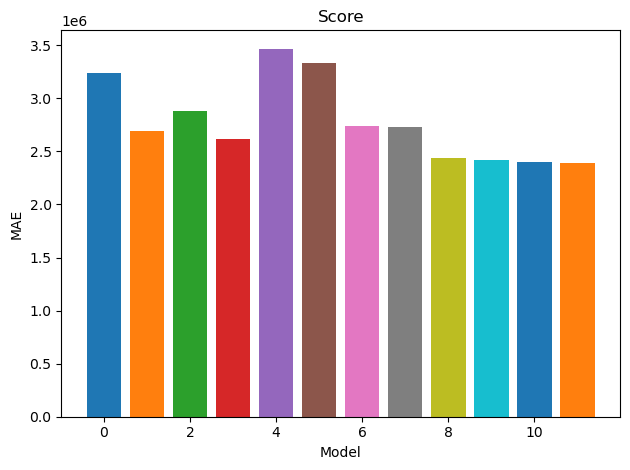

MODEL TIMES (s)
0. KNN_pred: 0.2155897617340088
2. KNN_select: 21.66078281402588
4. RegTrees_pred: 0.5558083057403564
6. RegTrees_select: 16.169135332107544
8. LinearReg_pred: 0.30195021629333496
10. LinearReg_select: 1.6062359809875488


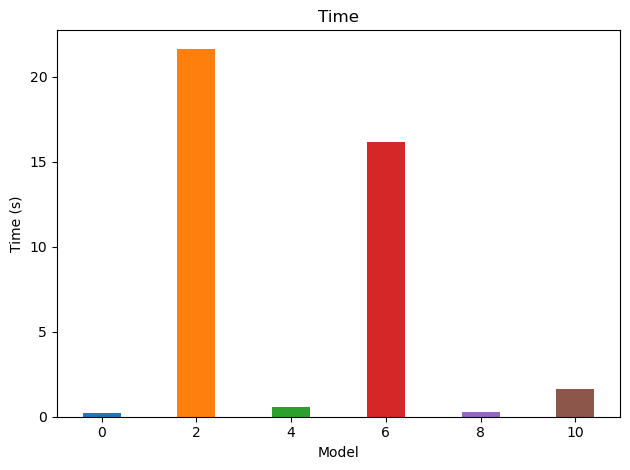

MODEL ATTRIBUTE SELECTION TIMES (s)
1. KNN_pred_k: 9.636045217514038
3. KNN_select_k: 5.894104719161987
5. RegTrees_pred_k: 2.886359453201294
7. RegTrees_select_k: 26.24833345413208
9. LinearReg_pred_k: 2.0286073684692383
11. LinearReg_select_k: 1.8783280849456787


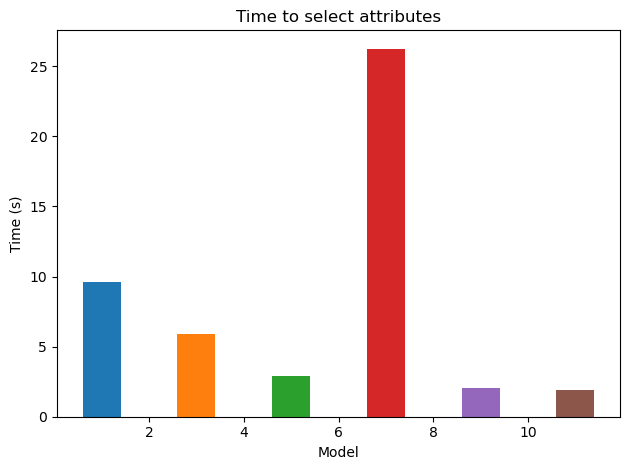

In [26]:
# Print the results up to now
# ! Plot the score
print("MODEL SCORES (NMAE in evaluation)")
iter = 0
for key, value in results.items():
    plt.bar(iter, abs(value[0]))
    print(f"{iter}. {key}: {abs(value[0])}")
    iter += 1
plt.title("Score")
plt.xlabel("Model")
plt.ylabel("MAE")
plt.tight_layout()

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/basic_methods_score.png")
plt.show()

# ! Plot the time (just the even ones == the ones that are not selectors of attributes)
print("MODEL TIMES (s)")
iter = 0
for key, value in times.items():
    if iter % 2 == 0:
        plt.bar(iter, value)
        print(f"{iter}. {key}: {value}")
    iter += 1
plt.title("Time")
plt.xlabel("Model")
plt.ylabel("Time (s)")
plt.tight_layout()

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/basic_methods_time.png")
plt.show()

# ! Plot the time (just the odd ones == the selectors of attributes)
print("MODEL ATTRIBUTE SELECTION TIMES (s)")
iter = 0
for key, value in times.items():
    if iter % 2 != 0:
        plt.bar(iter, value)
        print(f"{iter}. {key}: {value}")
    iter += 1
plt.title("Time to select attributes")
plt.xlabel("Model")
plt.ylabel("Time (s)")
plt.tight_layout()

# Exporting image as png to ../data/img folder - easier to visualize the annotations, better resolution
plt.savefig("../data/img/basic_methods_time_atb.png")
plt.show()

## 5.5. Conclusions: 

After computig the models we can see that the best model in terms of MAE is the LinearReg_selected, but the best timing model is LinearReg_pred.

***Obtener algunas conclusiones, tales como: ¿cuál es el mejor método? ¿Cuál de los métodos 
básicos de aprendizaje automático es más rápido? ¿Los resultados son mejores que los 
regresores triviales/naive/baseline? ¿El ajuste de hiperparámetros mejora con respecto a los 
valores por omisión? ¿Hay algún equilibrio entre tiempo de ejecución y mejora de 
resultados? Etc***



---
# 6. Reducing Dimensionality TODO
>¿Es posible reducir la dimensionalidad del problema?

Yes, it is possible to reduce the problem dimensionality, and as stated throughout the EDA, there are a lot of attributes that are highly correlated, so we can reduce the dimensionality of the problem by removing some of the attributes. Thus, it is recommended to use a PCA to reduce the dimensionality of the problem.

As mentioned in the EDA section, there are several attributes that are closely related to the point of being redundant. Our hypothesis is that dropping these features would not significantly affect the overall results. Additionally, we have implemented an additional step to detect and eliminate different attributes based on the model. We have done this by using the "SelectKBest" feature selector, which only considers the relationship between the attributes and the output variable. The tests designed to check the hypothesis will only contain the selected features from the SelectKBest step.

---
# 7. Advanced methods

In order to be consistent, although we have already seen that usign the selection of attributes makes the model better, we will continue to use the two-step method we have been doing. This way, we can also verify that the results are better than the ones obtained with the basic methods (for both with and without attribute selection).

## 7.1. Support Vector Machines (SVMs)

Support Vector Machine (SVM) is a supervised learning algorithm used for classification and regression analysis. SVM works by finding the hyperplane that best separates the data into different classes. The hyperplane is chosen such that it maximizes the margin between the closest data points from each class, known as support vectors. SVM can also use kernel functions to transform the input data into a higher dimensional space, allowing the separation of non-linearly separable data.

In [27]:
from sklearn.svm import SVR

### 7.1.1. SVMs - Predefined parameters

#### 7.1.1.1. SVMs - Predefined parameters - No attribute selection

In [32]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ('scaler', RobustScaler()),
        ("model", SVR())
    ]
)

param_grid = {
    "model__kernel": ["rbf"],
    "model__C": [1.0],
    "model__gamma": ["scale"],
    "model__epsilon": [0.1],
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
)


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["SVM_pred"] = model
results["SVM_pred"] = score
times["SVM_pred"] = total_time

print_results("SVM PREDEFINED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -6953343.12
RMSE train: 8058525.28	MAE train: 6899170.65
RMSE test: 7478465.50	MAE test: 6281604.09
---------------------------------------------------
SVM PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('model', SVR())]),
             param_grid={'model__epsilon': [0.1], 'model__gamma': ['scale'],
                         'model__kernel': ['rbf']},
             scoring='neg_mean_absolute_error')

Parameters: {'model__epsilon': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}

Performance: NMAE (val): -6953343.117286754 | RMSE train: 8058525.276321875 | MAE train: 6899170.647284467 | RMSE train: 7478465.501368871 | MAE test: 6281604.088961575
Execution time: 2.069565773010254s


#### 7.1.1.2. SVMs - Predefined parameters - Attribute selection

In [31]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", SVR()),
    ]
)

param_grid = {
    "model__kernel": ["rbf"],
    "model__C": [1.0],
    "model__gamma": ["scale"],
    "model__epsilon": [0.1],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["SVM_pred_k"] = model
results["SVM_pred_k"] = score
times["SVM_pred_k"] = total_time

print_results("SVM PREDEFINED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -6952999.55
RMSE train: 8057851.47	MAE train: 6898491.59
RMSE test: 7477858.61	MAE test: 6280965.57
---------------------------------------------------
SVM PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x7fbf8629ab90>)),
                                       ('model', SVR())]),
             n_jobs=-1,
             param_grid={'model__C': [1.0], 'model__epsilon': [0.1],
                         'model__gamma': ['scale'], 'model__kernel': ['rbf'],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 

### 7.1.2. SVMs - Selected parameters

Building upon the previous definition, we can reduce the most important parameters to be adjusted to the following for SVM:

- Kernel: This parameter defines the type of kernel used to transform the input data into a higher-dimensional space in order to perform classification. The most commonly used kernels are linear, polynomial, radial basis function (RBF), and sigmoid.
- C: This parameter determines the trade-off between maximizing the margin and minimizing the classification error. A smaller value of C creates a larger margin but may misclassify some data points, while a larger value of C may lead to overfitting.
- Gamma: This parameter defines the influence of each training example on the decision boundary. A smaller value of gamma makes the decision boundary smoother, while a larger value of gamma makes it more complex and can lead to overfitting.

#### 7.1.2.1. SVMs - Selected parameters - No attribute selection

In [44]:
np.random.seed(10)
budget = 15
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        # We scale the data to avoid overfitting - Recommended for SVMs
        ("model", SVR())
        # Support Vector Regression (SVR for regression, SVC for classification)
    ]
)

param_grid = {
    "model__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "model__C": [100000, 500000, 1000000, 5000000],
    "model__gamma": ["scale", "auto"],
}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["SVM_select"] = model
results["SVM_select"] = score
times["SVM_select"] = total_time

print_results("SVM SELECTED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2331773.95
RMSE train: 3384381.68	MAE train: 2251590.34
RMSE test: 3314781.26	MAE test: 2272204.42
---------------------------------------------------
SVM SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model', SVR())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'model__C': [100000, 1000000, 5000000],
                                        'model__gamma': ['scale', 'auto'],
                                        'model__kernel': ['linear', 'poly',
                                                          'rbf', 'sigmoid']},
                   scoring='neg_mean_absolute_error')

Parameters: {'model__kernel': 'linear', 'model__gamma': 'auto', 'model__C': 1000000}

Performance: NMAE (v

In [45]:
np.random.seed(10)
n_splits = 5

# We use Ridge as model as it is the best performing one
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", SVR())
    ]
)

# Previous model Parameters: {'model__kernel': 'linear', 'model__gamma': 'auto', 'model__C': 1000000}

param_grid = {
    "model__kernel": ["linear"],
    "model__C": [1000000],
    "model__gamma": ["auto"],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["SVM_select_k"] = model
results["SVM_select_k"] = score
times["SVM_select_k"] = total_time

print_results("SVM SELECTED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2331773.95
RMSE train: 3384381.68	MAE train: 2251590.34
RMSE test: 3314781.26	MAE test: 2272204.42
---------------------------------------------------
SVM SELECTED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('select',
                                        SelectKBest(score_func=<function f_regression at 0x7fbf8629ab90>)),
                                       ('model', SVR())]),
             n_jobs=-1,
             param_grid={'model__C': [1000000], 'model__gamma': ['auto'],
                         'model__kernel': ['linear'],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28,

## 7.2. Random Forests

Random forest is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class or mean prediction of the individual trees. Random forests improve on the decision tree model by reducing overfitting and increasing accuracy. This is achieved by generating multiple decision trees and then aggregating their predictions through a voting system.

In [47]:
from sklearn.ensemble import RandomForestRegressor

### 7.2.1. Random Forests - Predefined parameters

#### 7.2.1.1. Random Forests - Predefined parameters - No attribute selection

In [48]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline([("model", RandomForestRegressor(random_state=10))])

param_grid = {
    "model__n_estimators": [100],
    "model__criterion": ["squared_error"],
    "model__max_depth": [None],
    "model__min_samples_split": [2],
    "model__max_features": [None],
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["RandForest_pred"] = model
results["RandForest_pred"] = score
times["RandForest_pred"] = total_time

print_results("RANDOM FOREST PREDEFINED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2447807.29
RMSE train: 1249861.81	MAE train: 866788.80
RMSE test: 3157684.68	MAE test: 2212594.97
---------------------------------------------------
RANDOM FOREST PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model', RandomForestRegressor())]),
             param_grid={'model__criterion': ['squared_error'],
                         'model__max_depth': [None],
                         'model__max_features': [None],
                         'model__min_samples_split': [2],
                         'model__n_estimators': [100]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__criterion': 'squared_error', 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}

Performance: NMAE (val): -2447807.2894736845 | RMSE train: 1249861.8

#### 7.2.1.2. Random Forests - Predefined parameters - Attribute selection

In [49]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [("select", SelectKBest(f_regression)), ("model", RandomForestRegressor(random_state=10))]
)

param_grid = {
    "model__n_estimators": [100],
    "model__criterion": ["squared_error"],
    "model__max_depth": [None],
    "model__min_samples_split": [2],
    "model__max_features": [None],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["RandForest_pred_k"] = model
results["RandForest_pred_k"] = score
times["RandForest_pred_k"] = total_time

print_results("RANDOM FOREST PREDEFINED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2436340.53
RMSE train: 1230647.08	MAE train: 859275.53
RMSE test: 3167880.67	MAE test: 2219648.30
---------------------------------------------------
RANDOM FOREST PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('select',
                                        SelectKBest(score_func=<function f_regression at 0x7fbf8629ab90>)),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__criterion': ['squared_error'],
                         'model__max_depth': [None],
                         'model__max_features': [None],
                         'model__min_samples_split': [2],
                         'model__n_estimators': [100],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                       

### 7.2.2. Random Forests - Selected parameters

Building upon the previous definition, we can reduce the most important parameters to be adjusted to the following:

- n_estimators: controls the number of trees in the forest.
- max_depth: controls the maximum depth of each tree in the forest.
- min_samples_split: controls the minimum number of instances a leaf must have in order to be able to subdivide. This parameter can prevent the tree from overfitting.
- min_samples_leaf: controls the minimum number of instances required to be at a leaf node. Like min_samples_split, this parameter can also help prevent overfitting.

In [66]:
np.random.seed(10)
budget = 75
n_splits = 5

pipeline = Pipeline(
    [
        ("model", RandomForestRegressor(random_state=10))
    ]
)

param_grid = {
    "model__n_estimators": [100, 300, 800, 900],
    "model__max_depth": list(range(5, 36, 5)),
    "model__min_samples_split": [2, 3, 5, 7, 10],
    "model__max_features": ["sqrt", "log2"],
}

model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["RandForest_select"] = model
results["RandForest_select"] = score
times["RandForest_select"] = total_time

print_results("Random Forest", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2382299.52
RMSE train: 1425045.62	MAE train: 980722.47
RMSE test: 3052803.13	MAE test: 2107542.02
---------------------------------------------------
Random Forest best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('model',
                                              RandomForestRegressor(random_state=10))]),
                   n_iter=75, n_jobs=-1,
                   param_distributions={'model__max_depth': [5, 10, 15, 20, 25,
                                                             30, 35],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_split': [2, 3, 5, 7,
                                                                     10],
                                        'model__n_estimators': [100, 300, 800,
            

In [54]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [("select", SelectKBest(f_regression)), ("model", RandomForestRegressor(random_state=10))]
)

param_grid = {
    "model__n_estimators": [200],
    "model__max_depth": [11],
    "model__min_samples_split": [5],
    "model__max_features": ["sqrt"],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["RandForest_select_k"] = model
results["RandForest_select_k"] = score
times["RandForest_select_k"] = total_time

print_results("Random Forest", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2388704.04
RMSE train: 1779325.48	MAE train: 1287528.38
RMSE test: 3046110.91	MAE test: 2100753.02
---------------------------------------------------
Random Forest best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('select',
                                        SelectKBest(score_func=<function f_regression at 0x7fbf8629ab90>)),
                                       ('model',
                                        RandomForestRegressor(random_state=10))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [11],
                         'model__max_features': ['sqrt'],
                         'model__min_samples_split': [5],
                         'model__n_estimators': [200],
                         'select__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16

---
# 8. Best model
We will re-visit all the models and select the best one, which we have stated to be the one with the lowest MAE and the lowest RMSE.



0. Sected model: KNN_pred

Parameters: {'model__algorithm': 'auto', 'model__metric': 'minkowski', 'model__n_neighbors': 5, 'model__weights': 'uniform'}
Score NMAE in train-validation: -3239984.25
Score MAE (train): 2493007.2164383563 | Score RMSE (train): 3517654.379918169
Score MAE (test): 2932657.7260273974 | Score RMSE (test): 4052918.045996807
Time: 0.2155897617340088


1. Sected model: KNN_pred_k

Parameters: {'model__algorithm': 'auto', 'model__metric': 'minkowski', 'model__n_neighbors': 5, 'model__weights': 'uniform', 'select__k': 6}
Score NMAE in train-validation: -2690780.4078947366
Score MAE (train): 2162755.2657534247 | Score RMSE (train): 3108869.5243311627
Score MAE (test): 2636704.8493150687 | Score RMSE (test): 3817678.9396583214
Time: 9.636045217514038


2. Sected model: KNN_select

Parameters: {'model__weights': 'distance', 'model__n_neighbors': 17, 'model__metric': 'manhattan', 'model__algorithm': 'kd_tree'}
Score NMAE in train-validation: -2880131.5631625694
Score 

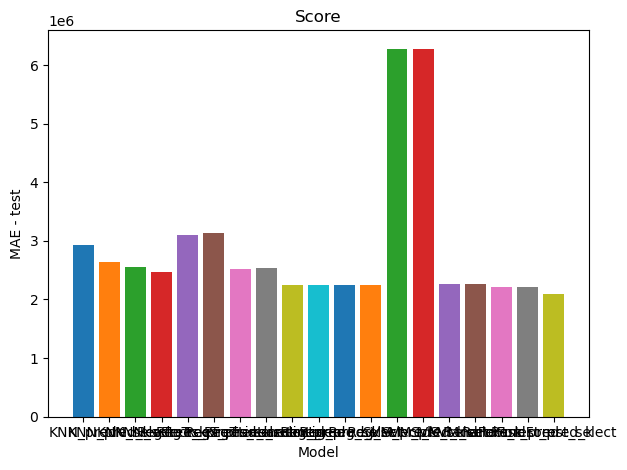

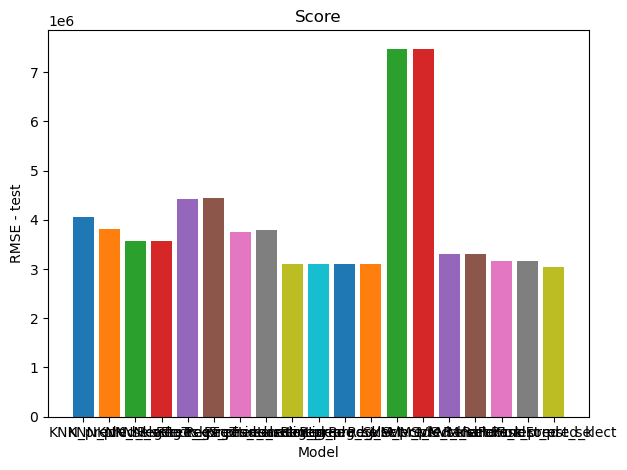

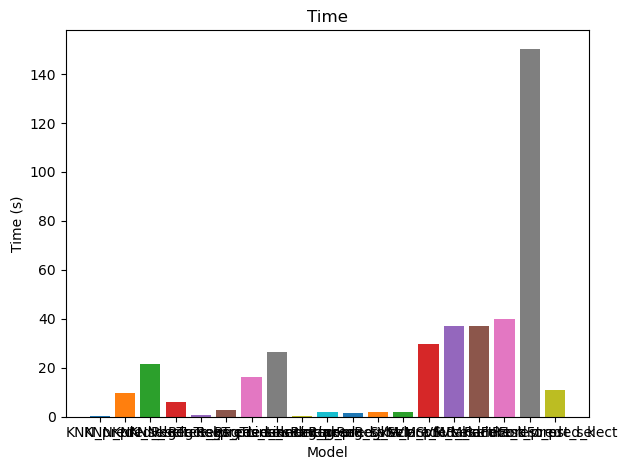

In [53]:
# ! Print the models best parameters
i = 0
for key, value in models.items():
    print(f"\n\n{i}. Sected model: {key}\n")
    print(f"Parameters: {value.best_params_}")
    print(f"Score NMAE in train-validation: {results[key][0]}")
    print(f"Score MAE (train): {results[key][2]} | Score RMSE (train): {results[key][1]}")
    print(f"Score MAE (test): {results[key][4]} | Score RMSE (test): {results[key][3]}")
    print(f"Time: {times[key]}")
    i+=1

# ! Plot the test score (MAE)
for key, value in results.items():
    plt.bar(key, abs(value[4]))
    # print(f"{key}: {abs(value[3])}")
plt.title("Score")
plt.xlabel("Model")
plt.ylabel("MAE - test")
plt.tight_layout()

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/basic_methods_score_mae.png")
plt.show()

# ! Plot the test score (RMSE)
for key, value in results.items():
    plt.bar(key, abs(value[3]))
    # print(f"{key}: {abs(value[2])}")
plt.title("Score")
plt.xlabel("Model")
plt.ylabel("RMSE - test")
plt.tight_layout()

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/basic_methods_score_rmse.png")
plt.show()

# ! Plot the time
for key, value in times.items():
    plt.bar(key, value)
plt.title("Time")
plt.xlabel("Model")
plt.ylabel("Time (s)")
plt.tight_layout()

# Exporting image as png to ../data/img folder - easier to visualize the annotations, better resolution
plt.savefig("../data/img/basic_methods_time.png")
plt.show()

## 8.2. Exportación del modelo seleccionado

In [ ]:
np.random.seed(10)

def train_best_model(selected_model):
    print("")

In [ ]:
import pickle
# Export final selected model (RandForest_select) -> 10th position
# Select the 9th position in the dictionary
selected_model = models["RandForest_select"]

# ! Entrenamos el modelo con los mejores datos
best_model = train_best_model(selected_model)

print(f"\nSelected model: {model}")

# Export model as pickle file in ../data/model folder
with open("../data/model/modelo_final.pkl", "wb") as file:
    pickle.dump(selected_model, file)

# ! Compare the model exported with the one loaded - check if it is the same
# Load model from pickle file
with open("../data/model/modelo_final.pkl", "rb") as file:
    loaded_model = pickle.load(file)

print(f"\nSaved model: {loaded_model}, {type(loaded_model)}, {loaded_model.best_params_}")
    
if selected_model.best_params_ == loaded_model.best_params_:
    print("\n\nThe models are the same")
else:
    print("\n\nERROR: The models are different")

---
# 9. Conclusiones

---
# X. Output the Jupyter Notebook as an HTML file

In [ ]:
import os

# Export the notebook to HTML
os.system("jupyter nbconvert --to html model.ipynb --output ../data/html/model.html")
print("Notebook exported to HTML")